Quel temps fait-il aujourd'hui?
<function questions at 0xaa75e150>
dire quelque chose
Tu as l'air bien aujourd'hui
Comment vas tu aujourd'hui?
<function questions at 0xaa75e150>
dire quelque chose
Tu as l'air bien aujourd'hui
Quel âge as tu?
<function questions at 0xaa75e150>
dire quelque chose
Essaye de penser à autre chose, ça va aller
Comment t'apelles tu?
<function questions at 0xaa75e150>
dire quelque chose
Tu as l'air bien aujourd'hui


ValueError: x and y must have same first dimension, but have shapes (0,) and (4,)

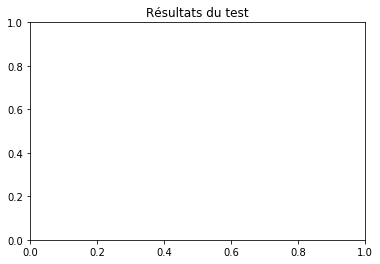

In [44]:
#import nécessaire
import matplotlib.pyplot as plt
from gtts import gTTS
import os
import time
import subprocess
from pydub import AudioSegment
import soundfile
from pynq.overlays.base import BaseOverlay
import numpy as np
from tempfile import TemporaryFile
import speech_recognition as sr
from googletrans import Translator
from watson_developer_cloud import SpeechToTextV1
from ibm_watson import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 import Features, SentimentOptions, EmotionOptions

#initialisation du microphone et écouteurs
base = BaseOverlay("base.bit")
pAudio = base.audio
pAudio.select_microphone()

text=''

#phrase réponse enregistrée
joie="Tu as l'air bien aujourd'hui"
colere="Calme toi, ce n'est pas grave, essaye de penser à autre chose"
peur="Ne t'inquiète pas, tout va bien se passer"
tristesse="Essaye de penser à autre chose, ça va aller"
degout="Passons vite à la question suivante"
defaut="ok, on passe à la question suivante"
erreur="Veux-tu que je répète la question oui ou non"
oui="Très bien, je répète la question"
debut="Hello, how are you"


#définition des variables globales
YES="Yes"
NO="No"
langueactuelle='fr-FR'
validation=0
posneg=list()
joy=list()
anger=list()
disgust=list()
sadness=list()
listquestions=list()
nombrequestions=list()
fear=list()

#récupération des questions
def questions(namefolder):
    fichier=open(namefolder,'r',encoding = 'unicode_escape') 
    text=fichier.read()
    numquest=1
    for interro in text.split('?'):
        interro = interro.replace(u'\xa0', u' ')
        interro = interro.replace(u'\n', u' ')
        listquestions.append(interro)
        nombrequestions.append(numquest)
        numquest=numquest+1
    fichier.close()
    nombrequestions.remove(len(nombrequestions))
    del listquestions[len(nombrequestions)]
    return listquestions,nombrequestions
                
#calcul de la moyenne et création de graphique
def moyennelistes(posneg,joy,anger,disgust,sadness,fear):
    #création des variables moyennes
    resposneg=''
    mposneg=0
    mjoy=0
    manger=0
    mdisgust=0
    msadness=0
    mfear=0
    #calcul des moyennes
    for element in posneg:
        mposneg=mposneg+element
    mposneg=mposneg/len(posneg)
    if mposneg<0:
        resposneg="/home/xilinx/jupyter_notebooks/test1folder/negatif.wav"
    elif mposneg>0:
        resposneg="/home/xilinx/jupyter_notebooks/test1folder/positif.wav"
    else:
        resposneg="/home/xilinx/jupyter_notebooks/test1folder/neutre.wav"
    for element in joy:
        mjoy=mjoy+element
    mjoy=mjoy/len(joy)
    for element in anger:
        manger=manger+element
    manger=manger/len(anger)
    for element in disgust:
        mdisgust=mdisgust+element
    mdisgust=mdisgust/len(disgust)
    for element in sadness:
        msadness=msadness+element
    msadness=msadness/len(sadness)
    for element in fear:
        mfear=mfear+element
    mfear=mfear/len(fear)
    #création des graphiques
    #graphique en fonction des résultats
    plt.figure(1)
    plt.title("Résultats du test")
    vnombrequest=np.array(nombrequestions)
    vjoy=np.array(joy)
    vanger=np.array(anger)
    vdisgust=np.array(disgust)
    vsadness=np.array(sadness)
    vfear=np.array(fear)
    plt.plot(vnombrequest,vjoy,'g',label="Joie")
    plt.plot(vnombrequest,vanger,'r',label="Colère")
    plt.plot(vnombrequest,vdisgust,'c',label="Dégoût")
    plt.plot(vnombrequest,vsadness,'m',label="Tristesse")
    plt.plot(vnombrequest,vfear,'y',label="Peur")
    plt.axis([0, len(nombrequestions), 0, 1])
    plt.xlabel('Numéro des questions')
    plt.ylabel('Résultats')
    plt.legend()
    plt.show()
    #graphique en fonction des moyennes
    plt.figure(2)
    plt.title("Résultats du test émotion")
    labels = 'Joie', 'Colère', 'Dégoût', 'Tristesse', 'Peur'
    plt.axis("equal")
    plt.pie([mjoy, manger, mdisgust, msadness, mfear],labels=labels,autopct="%1.1f")  
    plt.show()
    #affichage positif ou negatif 
    pAudio.load(resposneg)
    pAudio.play()
    
#conversion fichier .wav au bon format
def wavgoodform(namesourcefile):
    #conversion du fichier de départ en mono vers un fichier final en stéréo
    sound = AudioSegment.from_wav(namesourcefile)
    sound = sound.set_channels(2)
    sound.export("Voix001wavgoodversion.wav",format="wav")
    #conversion du fichier de départ en 16 bits vers un fichier en 24 bits
    data, samplerate = soundfile.read('Voix001wavgoodversion.wav')
    soundfile.write('f.wav', data, 48000, subtype='PCM_24')
    pAudio.load('f.wav')
    pAudio.play()
    
#enregistrement microphone
def micropynq():
    validation=0
    print("dire quelque chose")
    pAudio.record(4)
    audiotest = pAudio.save("recording_1.wav")
    r = sr.Recognizer()
    audiotest = sr.AudioFile("recording_1.wav")
    with audiotest as source: 
        audio = r.record(source)
    try:
        text=r.recognize_google(audio,language='fr-FR')
    except sr.UnknownValueError:
        validation=1
    while validation==0:
        pAudio.record(4)
        audiotest = pAudio.save("recording_1.wav")
        audiotest = sr.AudioFile("recording_1.wav")
        with audiotest as source: 
            audio = r.record(source)
        try:
            texttemp=r.recognize_google(audio,language='fr-FR')
            text=text+texttemp
        except sr.UnknownValueError:
            validation=1

#application principale
nmq=0
listquestions2=list()
listquestions2.append("Quel temps fait-il aujourd'hui?")
listquestions2.append("Comment vas tu aujourd'hui?")
listquestions2.append("Quel âge as tu?")
listquestions2.append("Comment t'apelles tu?")
for ask in listquestions2:
    print(ask)
    texttradaudio = gTTS(text=ask, lang=langueactuelle, slow=False)
    texttradaudio.save("askfile.mp3") 
    fildest="questions"+str(nmq)+".wav"
    subprocess.call(['ffmpeg', '-i', "askfile.mp3",fildest])
    sound = AudioSegment.from_wav(fildest)
    nmq=nmq+1
    sound = sound.set_channels(2)
    sound.export("Voix001wavgoodversion1.wav",format="wav")
    #conversion du fichier de départ en 16 bits vers un fichier en 24 bits
    data, samplerate = soundfile.read('Voix001wavgoodversion1.wav')
    soundfile.write('f.wav', data, 48000, subtype='PCM_24')
    pAudio.load('f.wav')
    pAudio.play()
    print(questions)
    #enregistrement réponse 
    r = sr.Recognizer()
    translator = Translator()
    validation=0
    print("dire quelque chose")
    pAudio.record(4)
    audiotest = pAudio.save("recording_1.wav")
    r = sr.Recognizer()
    audiotest = sr.AudioFile("recording_1.wav")
    with audiotest as source: 
        audio = r.record(source)
    try:
        text=r.recognize_google(audio,language='fr-FR')
    except sr.UnknownValueError:
        validation=1
    while validation==0:
        pAudio.record(4)
        audiotest = pAudio.save("recording_1.wav")
        audiotest = sr.AudioFile("recording_1.wav")
        with audiotest as source: 
            audio = r.record(source)
        try:
            texttemp=r.recognize_google(audio,language='fr-FR')
            text=text+texttemp
        except sr.UnknownValueError:
            validation=1
    time.sleep(3)
    translations = translator.translate(text)
    KEY_IBM = "74v192fabJsRIZYIahiYu15mrzTZ1F0ISEA9hCGIKU5t"
    URL_IBM="https://gateway-wdc.watsonplatform.net/natural-language-understanding/api"
    texttrad = translations.text
    alchemy_language = NaturalLanguageUnderstandingV1(version='2018-11-16',iam_apikey=KEY_IBM,url=URL_IBM)
    sentiment = alchemy_language.analyze(text=texttrad,features=Features(emotion=EmotionOptions(),sentiment=SentimentOptions())).get_result()
    #tri des données
    emo = sentiment['emotion']
    emo2 = emo['document']
    emo3 = emo2['emotion']
    #trouver l'émotion principale de la réponse
    emotionrepvaleur=list(emo3.keys())[list(emo3.values()).index(max(emo3.values()))]
    if emotionrepvaleur=='joy':
        repafaire=joie
    elif emotionrepvaleur=='anger':
        repafaire=colere
    elif emotionrepvaleur=='sadness':
        repafaire=tristesse
    elif emotionrepvaleur=='fear':
        repafaire=peur
    elif emotionrepvaleur=='disgust':
        repafaire=degout
    else:
        repafaire=defaut
    
    print(repafaire)
    #remplissage des listes des résultats
    joy.append(emo3['joy'])
    anger.append(emo3['anger'])
    disgust.append(emo3['disgust'])
    sadness.append(emo3['sadness'])
    fear.append(emo3['fear'])
    sent = sentiment['sentiment']
    sent2 = sent['document']
    sent3 = sent2['score']
    posneg.append(sent3)
moyennelistes(posneg,joy,anger,disgust,sadness,fear)   